In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import os
os.chdir('..')
sys.path.insert(0, os.getcwd())
import numpy as np

from AE_pipeline_pytorch import (
    LSTMAutoencoder,
    BiLSTMAutoencoder,
    
    GaitBatchIterable,

    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    evaluate_autoencoder,
    evaluate_autoencoder_streaming,

    GaitAutoencoder
)

import math
import torch
from time import time
from torch.utils.data import Dataset, DataLoader
import zarr
import torch.backends.cudnn as cudnn

import torch.nn as nn
import torch.optim as optim


2025-07-07 14:19:00.923041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751908740.938442  555976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751908740.943023  555976 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751908740.955605  555976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751908740.955625  555976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751908740.955627  555976 computation_placer.cc:177] computation placer alr

Using device: cuda


In [2]:
print(os.getcwd())

/home/dmartinez/Gait-Stability


In [3]:
#Data loader for Zarr datasets
batch_size = 16
train_loader = DataLoader(GaitBatchIterable("train_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


val_loader = DataLoader(GaitBatchIterable("val_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    GaitBatchIterable("test_cycles.zarr", batch_size=batch_size, return_meta=True), 
    batch_size=None, 
    num_workers=8,   
    shuffle=False,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


In [6]:
#To check the data loader
batch = next(iter(train_loader))
for i, item in enumerate(batch):
    print(f"Item {i}: type={type(item)}, shape={getattr(item, 'shape', None)}")

Item 0: type=<class 'torch.Tensor'>, shape=torch.Size([16, 100, 321])
Item 1: type=<class 'torch.Tensor'>, shape=torch.Size([16, 100, 321])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True
print(f"Using device: {device}")

Using device: cuda


In [5]:
#Train 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=256).to(device)


# Compila el modelo (PyTorch 2.0 JIT), **antes** de entrenar
#if hasattr(torch, "compile"):
   # model = torch.compile(model)


# Tu función de train_autoencoder acepta train_loader y val_loader
train_autoencoder(
    model,
    train_loader,
    val_loader,
    run_id="Torch7_256la_tanh_100ep_ini_l2",
    epochs=100,
    debug=False,
    debug_batches=60
)

Epoch 1/100: train_loss=0.9146, val_loss=0.9102


/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7eb42b75a6e0> was reported to be 486(when accessing len(dataloader)), but 487 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/home/dmartinez/miniconda3/envs/inv_Di/lib/python3.10/site-packages/torch/utils/data/dataloader.py:750: UserWarning: Length of IterableDataset <AE_pipeline_pytorch.GaitBatchIterable object at 0x7eb42b7581c0> was reported to be 105(when accessing len(dataloader)), but 106 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pyt

Epoch 2/100: train_loss=0.6402, val_loss=0.6117
Epoch 3/100: train_loss=0.4884, val_loss=0.5600
Epoch 4/100: train_loss=0.4440, val_loss=0.5373
Epoch 5/100: train_loss=0.4194, val_loss=0.5170
Epoch 6/100: train_loss=0.4012, val_loss=0.5024
Epoch 7/100: train_loss=0.3859, val_loss=0.4896
Epoch 8/100: train_loss=0.3714, val_loss=0.4797
Epoch 9/100: train_loss=0.3601, val_loss=0.4753
Epoch 10/100: train_loss=0.3519, val_loss=0.4672
Epoch 11/100: train_loss=0.3440, val_loss=0.4570
Epoch 12/100: train_loss=0.3357, val_loss=0.4524
Epoch 13/100: train_loss=0.3308, val_loss=0.4469
Epoch 14/100: train_loss=0.3229, val_loss=0.4407
Epoch 15/100: train_loss=0.3182, val_loss=0.4366
Epoch 16/100: train_loss=0.3129, val_loss=0.4284
Epoch 17/100: train_loss=0.3079, val_loss=0.4270
Epoch 18/100: train_loss=0.3038, val_loss=0.4350
Epoch 19/100: train_loss=0.2992, val_loss=0.4192
Epoch 20/100: train_loss=0.2944, val_loss=0.4135
Epoch 21/100: train_loss=0.2954, val_loss=0.4205
Epoch 22/100: train_loss=0.2

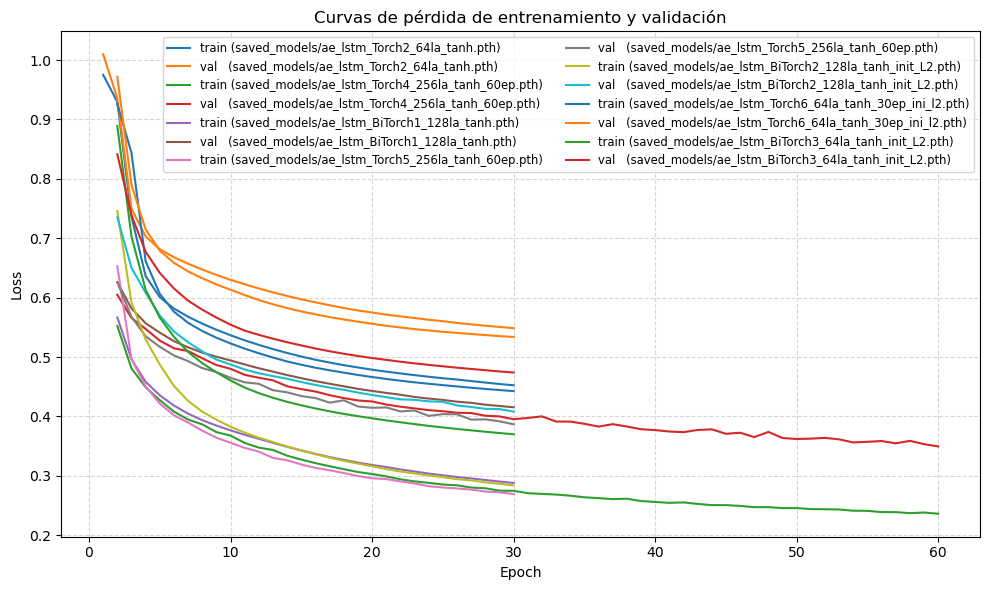

In [ ]:
#Plot results 
import re
import matplotlib.pyplot as plt

# 1) Leer el fichero de logs
with open('loss_results.txt', 'r', encoding='utf-8') as f:
    log_str = f.read()

# 2) Parsear por modelo
parts = re.split(r"\[SAVE\] Final model → ([^\n]+)", log_str)
data = {}
for i in range(1, len(parts), 2):
    model_name = parts[i].strip()
    segment    = parts[i-1]
    matches = re.findall(r"Epoch\s+(\d+)/\d+: train_loss=([\d\.]+), val_loss=([\d\.]+)", segment)
    if matches:
        epochs       = [int(e)       for e, _, _ in matches]
        train_losses = [float(t)     for _, t, _ in matches]
        val_losses   = [float(v)     for _, _, v in matches]
        data[model_name] = {'epoch': epochs, 'train': train_losses, 'val': val_losses}

# 3) Graficar todas las curvas en un único plot
plt.figure(figsize=(10, 6))
for model_name, d in data.items():
    plt.plot(d['epoch'], d['train'], label=f"train ({model_name})")
    plt.plot(d['epoch'], d['val'],   label=f"val   ({model_name})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Curvas de pérdida de entrenamiento y validación")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [5]:
#Train backbone
from torch.cuda.amp import autocast, GradScaler

torch.backends.cudnn.benchmark = True

model = GaitAutoencoder(input_channels=100, seq_length=321, latent_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()    # ①

num_epochs = 10
for epoch in range(num_epochs):
    # --- Entrenamiento ---
    model.train()
    total_loss = 0.0
    for x, _ in train_loader:
        x = x.float().to(device)
        optimizer.zero_grad()

        # ② Mixed precision forward + loss
        with autocast():
            x_recon, z = model(x)
            loss = criterion(x_recon, x)

        # ③ Backward y step con escalado
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # --- Validación ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.float().to(device)
            # opcional: también validar en autocast para consistencia memoria
            with autocast():
                x_recon, _ = model(x)
                total_val_loss += criterion(x_recon, x).item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}  '
          f'Train Loss: {avg_train_loss:.4f}  '
          f'Val Loss: {avg_val_loss:.4f}')
    

    torch.cuda.synchronize()
    print(torch.cuda.memory_summary())
    torch.cuda.empty_cache()



TypeError: GaitAutoencoder.__init__() got an unexpected keyword argument 'input_channels'

In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

device = torch.device('cpu')
if not torch.cuda.is_available() or device.type == 'cpu':
    torch.Tensor.pin_memory = lambda self: self

In [7]:
#Evaluate metrics 

model = LSTMAutoencoder(n_timesteps=100, n_vars=321, latent_dim=128).to(device)

# Load state dict and remove '_orig_mod.' prefix if present
state_dict = torch.load("saved_models/ae_lstm_Torch1.pth", map_location="cpu")
clean_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(clean_state_dict)

model.eval()

metrics = evaluate_autoencoder_streaming(model, train_loader, device)
print(metrics)



NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [ ]:
model.eval()
mse = torch.nn.MSELoss(reduction='none')

all_scores = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        recon = model(x)                       # (B, T, 321)
        # Si quieres comparar recon vs y, quizá tu función `evaluate_and_detect`
        # espera (x, y) y devuelve errores. Sino:
        # ejemplo de score: media de MSE por variable
        loss = mse(recon, x).mean(dim=(1,2))   # reconstrucción de x vs x
        # o si tu supervisión es recon vs y:
        # loss = mse(recon, y).mean(dim=(1,2))
        all_scores.append(loss.cpu())

all_scores = torch.cat(all_scores)
print("Test MSE (batch-wise):", all_scores.mean().item())
